### 0. Notebook setup

In [1]:
COLAB = False # Set this to True if you want to install the libraries and clone the repository in Colab
USE_DOTENV = True # Set this to False if you don't have a .env file for storing environment variables

if COLAB:
    USE_DOTENV = False
    dotenv_path = None
    from google.colab import userdata
    colab_secrets = {'HF_TOKEN': userdata.get('HF_TOKEN'), 'HF_TOKEN_WRITE': userdata.get('HF_TOKEN_WRITE')}
    !pip install datasets
    !git clone https://github.com/reddgr/zero-shot-text-classification
    import os
    os.system("mv zero-shot-text-classification zs_tc")

if USE_DOTENV: 
    COLAB=False
    dotenv_path = "../../../../../apis/.env"
    colab_secrets = None

from transformers import pipeline, AutoModelForSequenceClassification, TFAutoModelForSequenceClassification, AutoTokenizer
import tensorflow as tf
import random
from datasets import load_dataset, Dataset
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
import sys
import os
import torch
import textwrap
from IPython.display import clear_output
import matplotlib.pyplot as plt

if COLAB:
    import sys
    sys.path.append("./zs_tc/src")
    import env_options, nli_labeling_widget as labeling_widget, text_classification_functions as tcf, lmsys_dataset_handler as lmsys
else:
    import sys
    sys.path.append("./src")
    import text_classification_functions as tcf
    import env_options
    import lmsys_dataset_handler as lmsys
    import nli_finetuning_utils

hf_token, hf_token_write, openai_api_key = env_options.check_env(colab=COLAB, use_dotenv=USE_DOTENV, 
                                                 dotenv_path=dotenv_path, colab_secrets=colab_secrets)


Python version: 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
PyTorch version: 2.2.2
Transformers version: 4.44.2
CUDA device: NVIDIA GeForce RTX 4060 Laptop GPU
CUDA Version: 12.1
FlashAttention available: True
Retrieved token(s) from .env file
Using HuggingFace token: hf_M*****************************IASJ
Using HuggingFace write token: hf_u*****************************Xipx
Using OpenAI token: sk-p************************************************************************************************************************************************************_5sA


In [2]:
### DEBUG ###
import importlib
importlib.reload(nli_finetuning_utils)
### DEBUG ###

<module 'nli_finetuning_utils' from 'c:\\Users\\david\\Documents\\git\\zero-shot-text-classification\\./src\\nli_finetuning_utils.py'>

## Preparing test datasets

Loading the Test dataset

In [2]:
test_dataset_dict = load_dataset("reddgr/nli-chatbot-prompt-categorization")
test_dataset = test_dataset_dict["test"]  # Access the "test" split
test_dataset_df = test_dataset_dict["test"].to_pandas()
print("Labels: ",test_dataset_dict["test"].features["label"]._str2int)
entailments_test_dataset_df = test_dataset_df[test_dataset_df['label'] == 2]
display(entailments_test_dataset_df.head(3))
print(f'... {len(entailments_test_dataset_df)} records ...')
display(entailments_test_dataset_df.tail(3))

Labels:  {'contradiction': 0, 'neutral': 1, 'entailment': 2}


,text,category,label
5,I wanna have a conversation in german to practice,language,2
7,What you think about Belarus?,general knowledge,2
9,Help me rephrase this tagline by giving me a f...,language,2


... 213 records ...


,text,category,label
405,Write some html code that will play a graphics...,coding,2
409,"How do you think, what can be the potential ne...",ai,2
411,When I was 6 my sister was half my age. Now I’...,riddle,2


### Define category lists for test metrics

10 categories:

In [3]:
category_counts = entailments_test_dataset_df['category'].value_counts()
top_n_filter = 10
print(f'Top {top_n_filter} prompt categories (Test split):\n{category_counts.head(top_n_filter)}')
# We exclude "general knowledge" from the tests given the high ambiguity of the category
category_counts = category_counts[category_counts.index != 'general knowledge']
top_categories = category_counts.head(top_n_filter).index
test_entailments_df = entailments_test_dataset_df[entailments_test_dataset_df['category'].isin(top_categories)]
print(f'{len(test_entailments_df)} records for testing {top_n_filter} categories')
test_entailments_dataset = Dataset.from_pandas(test_entailments_df)
print(test_entailments_dataset)
print(top_categories.to_list())

Top 10 prompt categories (Test split):
category
coding               39
technology           25
language             20
writing              20
science              19
business             18
popular culture      11
role play            10
general knowledge     9
riddle                8
Name: count, dtype: int64
175 records for testing 10 categories
Dataset({
    features: ['text', 'category', 'label', '__index_level_0__'],
    num_rows: 175
})
['coding', 'technology', 'language', 'writing', 'science', 'business', 'popular culture', 'role play', 'riddle', 'finance']


Grouped categories:

In [4]:
test_df_grouped = entailments_test_dataset_df.copy()
test_df_grouped.loc[test_df_grouped['category'] == 'business', 'category'] = 'business and finance'
test_df_grouped.loc[test_df_grouped['category'] == 'finance', 'category'] = 'business and finance'
test_df_grouped.loc[test_df_grouped['category'] == 'language', 'category'] = 'language and writing'
test_df_grouped.loc[test_df_grouped['category'] == 'writing', 'category'] = 'language and writing'
test_df_grouped.loc[test_df_grouped['category'] == 'popular culture', 'category'] = 'culture and entertainment'
test_df_grouped.loc[test_df_grouped['category'] == 'music', 'category'] = 'culture and entertainment'
test_df_grouped.loc[test_df_grouped['category'] == 'entertainment', 'category'] = 'culture and entertainment'
test_df_grouped.loc[test_df_grouped['category'] == 'technology', 'category'] = 'technology and ai'
test_df_grouped.loc[test_df_grouped['category'] == 'ai', 'category'] = 'technology and ai'
category_counts = test_df_grouped['category'].value_counts()
top_n_display = 10
print(f'Top {top_n_display} prompt categories:\n{category_counts.head(top_n_display)}')
category_counts = category_counts[category_counts.index != 'general knowledge']
top_n_categories = 6
top_grouped_categories = category_counts.head(top_n_categories).index
test_entailments_grouped = test_df_grouped[test_df_grouped['category'].isin(top_grouped_categories)]
print(f'{len(test_entailments_grouped)} records for testing {top_n_categories} category groups')
print(top_grouped_categories.to_list())

Top 10 prompt categories:
category
language and writing         40
coding                       39
technology and ai            30
business and finance         23
science                      19
culture and entertainment    15
role play                    10
general knowledge             9
riddle                        8
philosophy                    4
Name: count, dtype: int64
166 records for testing 6 category groups
['language and writing', 'coding', 'technology and ai', 'business and finance', 'science', 'culture and entertainment']


## Tests metrics for current model

No need to run these cells if there's no new version of the model

### 10-category test (current model)

Zero-shot classification with reddgr/zero-shot-prompt-classifier-bart-ft:   0%|          | 0/171 [00:00<?, ?it/s]c:\Users\david\anaconda3\Lib\site-packages\transformers\models\bart\modeling_bart.py:496: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Zero-shot classification with reddgr/zero-shot-prompt-classifier-bart-ft:   6%|▋         | 11/171 [00:01<00:29,  5.36it/s]You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Zero-shot classification with reddgr/zero-shot-prompt-classifier-bart-ft: 100%|██████████| 171/171 [00:31<00:00,  5.36it/s]


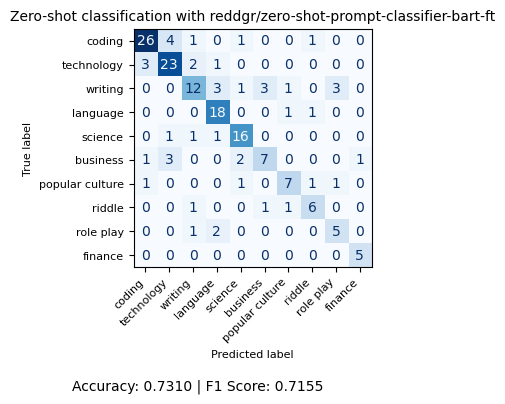

In [5]:
nli_model_path = 'reddgr/zero-shot-prompt-classifier-bart-ft'
zs_classifier_10 = tcf.ZeroShotClassifier(nli_model_path, nli_model_path, top_categories)
zs_test_metrics = zs_classifier_10.test_zs_predictions(test_entailments_df)

### 6 grouped categories test (current model)

Zero-shot classification with reddgr/zero-shot-prompt-classifier-bart-ft: 100%|██████████| 160/160 [00:22<00:00,  7.03it/s]


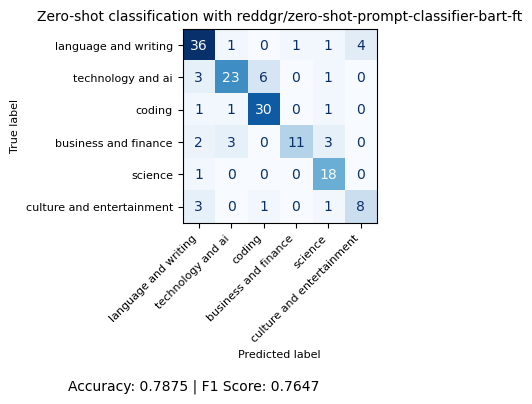

In [6]:
nli_model_path = 'reddgr/zero-shot-prompt-classifier-bart-ft'
zs_classifier_grouped = tcf.ZeroShotClassifier(nli_model_path, nli_model_path, top_grouped_categories)
zs_test_metrics_grouped = zs_classifier_grouped.test_zs_predictions(test_entailments_grouped)

## Finetuning

Loading the Train split:

In [5]:
SAMPLING = False
dataset_dict = load_dataset("reddgr/nli-chatbot-prompt-categorization")
hf_dataset = dataset_dict["train"]

if SAMPLING:
    n_samples = 1000
    RANDOM_SAMPLING = True
    if not RANDOM_SAMPLING:
        # SAMPLING ONLY LATEST n_samples RECORDS
        total_samples = len(hf_dataset)
        hf_dataset = dataset_dict["train"].select(range(total_samples - n_samples, total_samples))
    else:
        # SAMPLING RANDOMLY n_samples RECORDS
        hf_dataset = dataset_dict["train"].shuffle().select(range(n_samples))

hf_dataset = hf_dataset.rename_column('category', 'class')

hf_dataset_df = hf_dataset.to_pandas()
print("Labels: ",dataset_dict["train"].features["label"]._str2int)

display(hf_dataset_df.head(3))
print(f'... {len(hf_dataset_df)} records ...')
display(hf_dataset_df.tail(3))

Labels:  {'contradiction': 0, 'neutral': 1, 'entailment': 2}


,text,class,label
0,pretent you're a hotel manager who received th...,role play,2
1,Write a single dot\n,coding,0
2,Write an article about the Applications of 2-E...,language,1


... 1994 records ...


,text,class,label
1991,Which planets are visible in the night sky ove...,science,2
1992,Which planets are visible in the night sky ove...,language,0
1993,Which planets are visible in the night sky ove...,riddle,0


Tokenizing and formatting the dataset:

In [6]:
nli_tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large-mnli', clean_up_tokenization_spaces=True)
nli_model = AutoModelForSequenceClassification.from_pretrained('facebook/bart-large-mnli', clean_up_tokenization_spaces=True)
print(f"Loaded NLI model with head:\n{nli_model.classification_head.out_proj}\n{nli_model.config.id2label}")

# top_categories =['technology', 'language', 'coding', 'science', 'business', 'writing', 'popular culture', 'role play', 'riddle', 'general knowledge']
# Instantiate the NLIModelFineTuner class
fine_tuner = nli_finetuning_utils.NLIModelFineTuner(hf_dataset, top_grouped_categories, nli_model, nli_tokenizer)

# Tokenize and format the dataset
template = "This example is a {} prompt."
max_length = 128
eval_proportion = 0.2

train_dataset, eval_dataset, full_dataset = fine_tuner.tokenize_and_format_nli_dataset(template, max_length, eval_proportion)
print(f"Train dataset: {len(train_dataset)}, Eval dataset: {len(eval_dataset)}")
print(top_grouped_categories)
print("\nInput sentence example:")
random_index = random.randint(0, len(train_dataset))
print(train_dataset.to_pandas()['input_sentence'].iloc[random_index])
print(f"Label: {train_dataset.to_pandas()['labels'].iloc[random_index]}", 
      f"({dataset_dict['train'].features['label']._int2str[train_dataset.to_pandas()['labels'].iloc[random_index]]})")

Loaded NLI model with head:
Linear(in_features=1024, out_features=3, bias=True)
{0: 'contradiction', 1: 'neutral', 2: 'entailment'}
Train dataset: 1595, Eval dataset: 399
Index(['language and writing', 'coding', 'technology and ai',
       'business and finance', 'science', 'culture and entertainment'],
      dtype='object', name='category')

Input sentence example:
<prompt>Please play Trump and talk to me</prompt> This example is a science prompt.
Label: 0 (contradiction)


#### Fine-tuning:

Loading model and tokenizer:

In [13]:
model = AutoModelForSequenceClassification.from_pretrained('facebook/bart-large-mnli', clean_up_tokenization_spaces=True)
# model = AutoModelForSequenceClassification.from_pretrained('reddgr/zero-shot-prompt-classifier-bart-ft', clean_up_tokenization_spaces=True)
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large-mnli', clean_up_tokenization_spaces=True)
print("model_type: ",model.config.model_type)
print("model_input_names: ",tokenizer.model_input_names)
print("num_labels: ",model.config.num_labels)
print("max_position_embeddings: ",getattr(model.config, "max_position_embeddings", None))

model_type:  bart
model_input_names:  ['input_ids', 'attention_mask']
num_labels:  3
max_position_embeddings:  1024


In [7]:
learning_rate=2e-5 # 1e-5 # 5e-6
n_epochs=2.4 ##### 2.5
bsize=32 # 32 if you have the memory
t_max=8 ### 10
# trainer = fine_tuner.fine_tune(output_dir="./models", epochs=n_epochs, batch_size=bsize, learning_rate=learning_rate)
trainer, train_results = fine_tuner.fine_tune_with_cosine_annealing("./models", n_epochs, bsize, learning_rate, t_max)

Using device: cuda:0
Fine-tuning in progress...


  0%|          | 0/120 [00:00<?, ?it/s]

Last learning rate: 2e-05


c:\Users\david\anaconda3\Lib\site-packages\transformers\models\bart\modeling_bart.py:496: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation param


Epoch 1.0 complete.


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.7438200116157532, 'eval_runtime': 46.8243, 'eval_samples_per_second': 8.521, 'eval_steps_per_second': 1.068, 'epoch': 1.0}
Last learning rate: 1.7071067811865647e-05


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-defau


Epoch 2.0 complete.


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.6733681559562683, 'eval_runtime': 46.9019, 'eval_samples_per_second': 8.507, 'eval_steps_per_second': 1.066, 'epoch': 2.0}
Last learning rate: 9.999999999999955e-06


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'forced_eos_token_id': 2}



Epoch 2.4 complete.


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.7052295804023743, 'eval_runtime': 45.7566, 'eval_samples_per_second': 8.72, 'eval_steps_per_second': 1.093, 'epoch': 2.4}
{'train_runtime': 1739.4623, 'train_samples_per_second': 2.201, 'train_steps_per_second': 0.069, 'train_loss': 0.608479118347168, 'epoch': 2.4}
Fine-tuning complete. Model saved to ./models.
Last checkpoint 120


In [8]:
for obj in trainer.state.log_history:
    print(obj)
metrics = train_results.metrics
print(f"Train metrics: {metrics}")
print(trainer.state.global_step)

{'eval_loss': 0.7438200116157532, 'eval_runtime': 46.8243, 'eval_samples_per_second': 8.521, 'eval_steps_per_second': 1.068, 'epoch': 1.0, 'step': 50}
{'eval_loss': 0.6733681559562683, 'eval_runtime': 46.9019, 'eval_samples_per_second': 8.507, 'eval_steps_per_second': 1.066, 'epoch': 2.0, 'step': 100}
{'eval_loss': 0.7052295804023743, 'eval_runtime': 45.7566, 'eval_samples_per_second': 8.72, 'eval_steps_per_second': 1.093, 'epoch': 2.4, 'step': 120}
{'train_runtime': 1739.4623, 'train_samples_per_second': 2.201, 'train_steps_per_second': 0.069, 'total_flos': 1032468039014580.0, 'train_loss': 0.608479118347168, 'epoch': 2.4, 'step': 120}
Train metrics: {'train_runtime': 1739.4623, 'train_samples_per_second': 2.201, 'train_steps_per_second': 0.069, 'total_flos': 1032468039014580.0, 'train_loss': 0.608479118347168, 'epoch': 2.4}
120


In [11]:
checkpoint_step = trainer.state.global_step
print(f"Last checkpoint step: {checkpoint_step}")

Last checkpoint step: 120


MANUAL SAVE:

Save the model (if not saved already):

In [14]:
output_dir = "./models/checkpoint-evloss705"
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Model and tokenizer saved to: {output_dir}")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'forced_eos_token_id': 2}


Model and tokenizer saved to: ./models/checkpoint-evloss705


Load saved model:

In [15]:
# checkpoint_step = 81
checkpoint_step = trainer.state.global_step
# checkpoint_step = 'evloss72' # best
# checkpoint_step = 'evloss76' # best
checkpoint_step = 'evloss705' # 
fine_tuned_model = AutoModelForSequenceClassification.from_pretrained(f"./models/checkpoint-{checkpoint_step}")
print(f"Loaded model from: ./models/checkpoint-{checkpoint_step}")

Loaded model from: ./models/checkpoint-evloss705


### Grouped categories test

sequence: When I was 6 my sister was half my age. Now I’m 70. How old is my sister? Let's think step by step
labels: ['culture and entertainment', 'language and writing', 'technology and ai', 'science', 'business and finance', 'coding']
scores: [0.263, 0.21, 0.154, 0.147, 0.123, 0.104]


Zero-shot classification with ./models/checkpoint-evloss705:   6%|▌         | 10/166 [00:03<01:07,  2.32it/s]You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Zero-shot classification with ./models/checkpoint-evloss705: 100%|██████████| 166/166 [01:10<00:00,  2.37it/s]


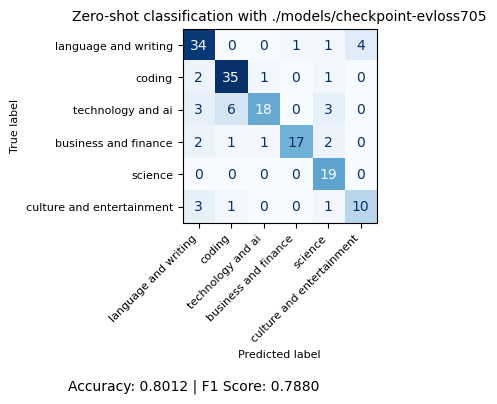

In [16]:
finetuned_model_path=f"./models/checkpoint-{checkpoint_step}"
tokenizer_path="facebook/bart-large-mnli"
# zs_classifier_finetuned = tcf.ZeroShotClassifier(finetuned_model_path, tokenizer_path, top_categories)
zs_classifier_finetuned = tcf.ZeroShotClassifier(finetuned_model_path, tokenizer_path, top_grouped_categories)
text_sample = test_entailments_df.sample(1, random_state=38).text.values[0]
result = zs_classifier_finetuned.classify_text(text_sample, multi_label=False)
clear_output(wait=True)
for key, value in result.items():
    print(f"{key}: {value}")

zs_test_metrics_ft_grouped = zs_classifier_finetuned.test_zs_predictions(test_entailments_grouped)

### 10-category test

c:\Users\david\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Zero-shot classification with ./models/checkpoint-evloss705: 100%|██████████| 175/175 [08:41<00:00,  2.98s/it]


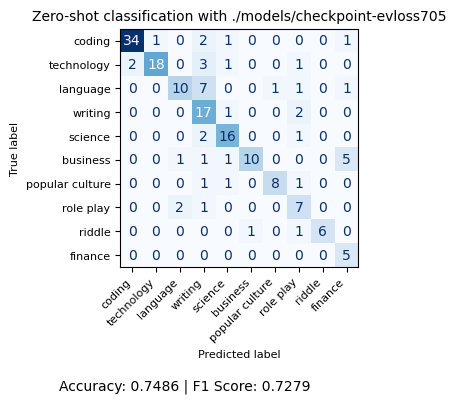

In [17]:
finetuned_model_path=f"./models/checkpoint-{checkpoint_step}"
tokenizer_path="facebook/bart-large-mnli"
zs_classifier_finetuned = tcf.ZeroShotClassifier(finetuned_model_path, tokenizer_path, top_categories)
zs_test_metrics_ft = zs_classifier_finetuned.test_zs_predictions(test_entailments_df)

In [14]:
zs_test_metrics_ft.get('detailed_results')
results_df = pd.DataFrame(zs_test_metrics_ft['detailed_results'])
display(results_df.sample(5))
results_df.to_csv('csv/10c-test.csv', index=False)

,text,category,label,predicted_class
352,"os.environ[""KERAS_BACKEND""] = ""jax"" # or ""ten...",coding,2,coding
317,"Elaborate more, now based on your own research...",technology,2,technology
194,peripheral neuropathy causes,science,2,science
264,whats the miminal ram requirement?,technology,2,riddle
305,Now suggest a few titles for the thesis. Manda...,writing,2,writing


### Testing specific prompts

In [16]:
base_model_path = 'facebook/bart-large-mnli'
base_classifier = tcf.ZeroShotClassifier(base_model_path, base_model_path, top_categories)

nli_model_path = 'reddgr/zero-shot-prompt-classifier-bart-ft'
zs_classifier = tcf.ZeroShotClassifier(nli_model_path, base_model_path, top_categories)
zs_classifier_finetuned = tcf.ZeroShotClassifier(finetuned_model_path, base_model_path, top_categories)

# text_sample = test_entailments_df.sample(1).text.values[0]
text_sample = "I'm twice the age you were when i was your age. How old are we?"
text_sample = "how to find out my phone number on android?"
# text_sample = "what is a funny made-up origin story of the empire state building?"
ft_result = zs_classifier_finetuned.classify_text(text_sample, multi_label=False)
base_result = base_classifier.classify_text(text_sample, multi_label=False)
current_result = zs_classifier.classify_text(text_sample, multi_label=False)
clear_output(wait=True)

print("Classification with base model:")
for key, value in base_result.items():
    print(f"{key}: {value}")

print("\nClassification with model fine-tuned in this session:")
for key, value in ft_result.items():
    print(f"{key}: {value}")


print("\nClassification with most recent fine-tuned model:")
for key, value in current_result.items():
    print(f"{key}: {value}")

Classification with base model:
sequence: how to find out my phone number on android?
labels: ['technology', 'riddle', 'language', 'writing', 'role play', 'coding', 'popular culture', 'finance', 'business', 'science']
scores: [0.461, 0.396, 0.029, 0.027, 0.023, 0.017, 0.014, 0.012, 0.011, 0.009]

Classification with model fine-tuned in this session:
sequence: how to find out my phone number on android?
labels: ['technology', 'riddle', 'coding', 'writing', 'role play', 'language', 'business', 'popular culture', 'finance', 'science']
scores: [0.532, 0.232, 0.126, 0.029, 0.024, 0.015, 0.015, 0.012, 0.01, 0.006]

Classification with most recent fine-tuned model:
sequence: how to find out my phone number on android?
labels: ['technology', 'coding', 'riddle', 'role play', 'business', 'writing', 'finance', 'popular culture', 'science', 'language']
scores: [0.687, 0.151, 0.086, 0.015, 0.013, 0.013, 0.01, 0.009, 0.008, 0.008]


Accuracy by labeled category:

In [17]:
zs_test_metrics_ft.get('detailed_results')
results_df = pd.DataFrame(zs_test_metrics_ft['detailed_results'])
results_by_category = results_df.groupby(['category', 'predicted_class']).size().unstack(fill_value=0)
accuracy_by_category = results_df.groupby('category').apply(lambda x: (x['category'] == x['predicted_class']).mean())

print("\nAccuracy by category:")
for category in top_categories:
    print(f"{category:20} {accuracy_by_category[category]:.3f}")

print("\nResults sample:")
display(results_df.sample(5))


Accuracy by category:
coding               0.897
technology           0.720
language             0.650
writing              0.700
science              0.842
business             0.833
popular culture      0.636
role play            0.800
riddle               0.625
finance              0.800

Results sample:


,text,category,label,predicted_class
86,How many languages do you understand?,language,2,language
376,can chief of staff and director human resource...,business,2,business
101,i have an xml of old texts how could i restore...,technology,2,technology
48,"give me a project idea for python, rabbitmq, m...",coding,2,coding
221,what are water molecules?,science,2,science


In [19]:
zs_test_metrics_ft.get('detailed_results')
results_df = pd.DataFrame(zs_test_metrics_ft['detailed_results'])
display(results_df.sample(5))
results_df.to_csv('csv/10c-test-ft.csv', index=False)

,text,category,label,predicted_class
215,Hey! Can you please explain how chatgpt works?,technology,2,technology
54,You and I meet for the first time. You are a g...,role play,2,role play
24,Can you make this link have color #353535 only...,coding,2,coding
135,Make a very annoying email with lots of errors...,role play,2,role play
354,how do I change col names of datos_descargados...,coding,2,coding


#### Push to hub:

In [20]:
fine_tuner.model.push_to_hub("reddgr/zero-shot-prompt-classifier-bart-ft", token=hf_token_write)
fine_tuner.tokenizer.push_to_hub("reddgr/zero-shot-prompt-classifier-bart-ft", token=hf_token_write)

README.md:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

c:\Users\david\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\david\.cache\huggingface\hub\models--reddgr--zero-shot-prompt-classifier-bart-ft. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some non-default generation parameters are set in the model config. These should go into a Genera

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/reddgr/zero-shot-prompt-classifier-bart-ft/commit/f87341898a2861448dac82257f708419d6294322', commit_message='Upload tokenizer', commit_description='', oid='f87341898a2861448dac82257f708419d6294322', pr_url=None, pr_revision=None, pr_num=None)

## Tensorflow Fine-Tuning

In [ ]:
dataset_dict = load_dataset("reddgr/nli-chatbot-prompt-categorization")
hf_dataset = dataset_dict["train"]
hf_dataset = hf_dataset.rename_column('category', 'class')
hf_dataset_df = hf_dataset.to_pandas()
print("Labels: ",dataset_dict["train"].features["label"]._str2int)
display(hf_dataset_df.head(3))
print(f'... {len(hf_dataset_df)} records ...')
display(hf_dataset_df.tail(3))

In [ ]:
#from tensorflow.keras import mixed_precision
#policy = mixed_precision.Policy('mixed_float16')
#mixed_precision.set_global_policy(policy)

# Main parameters:
learning_rate=5e-6
n_epochs=5

# Split data into train and eval sets
dataset_split = hf_dataset.train_test_split(test_size=0.5, seed=38)
train_dataset = dataset_split['train']
# This is not the original Test set, but a validation set
# train_test_split generates it with the name 'test', not to be confused with the 'test' split of the original dataset
eval_dataset = dataset_split['test']

tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large-mnli')
model = TFAutoModelForSequenceClassification.from_pretrained('facebook/bart-large-mnli', num_labels=3)

def tokenize_function(examples, tokenizer=tokenizer):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

# tokenized_dataset = dataset.map(lambda x: tokenize_function(x, tokenizer), batched=True)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_eval_dataset = eval_dataset.map(tokenize_function, batched=True)

# Convert tokenized datasets to TensorFlow datasets
train_tf_dataset = tokenized_train_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["label"],
    shuffle=True,
    batch_size=8
)

eval_tf_dataset = tokenized_eval_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["label"],
    shuffle=False,
    batch_size=8
)
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

clear_output(wait=True) # remove library warnings
history = model.fit(
    train_tf_dataset,
    validation_data=eval_tf_dataset,
    epochs=n_epochs
)
clear_output(wait=True)

# Plot training and validation losses and accuracies in a 1x2 grid
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
epochs = range(1, len(history.history['loss']) + 1)

# Plot losses
axes[0].plot(epochs, history.history['loss'], label='Train Loss')
axes[0].plot(epochs, history.history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()

# Plot accuracies
axes[1].plot(epochs, history.history['accuracy'], label='Train Accuracy')
axes[1].plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

model.save_pretrained("fine-tuned-bart-nli-testing")
tokenizer.save_pretrained("fine-tuned-bart-nli-testing")

# BASIC TEST
test_dataset_dict = load_dataset("reddgr/nli-chatbot-prompt-categorization")
test_dataset = test_dataset_dict["test"]  # Access the "test" split
test_dataset_df = test_dataset_dict["test"].to_pandas()
entailments_test_dataset_df = test_dataset_df[test_dataset_df['label'] == 2]
category_counts = entailments_test_dataset_df['category'].value_counts()
top_n_filter = 10
top_categories = category_counts.head(top_n_filter).index
test_entailments_df = entailments_test_dataset_df[entailments_test_dataset_df['category'].isin(top_categories)]
test_entailments_dataset = Dataset.from_pandas(test_entailments_df)

nli_model_path = 'fine-tuned-bart-nli-testing'
zs_classifier_finetuned = tcf.ZeroShotClassifier(nli_model_path, nli_model_path, top_categories)
text_sample = test_entailments_df.sample(1).text.values[0]
result = zs_classifier_finetuned.classify_text(text_sample, multi_label=False)
for key, value in result.items():
    print(f"{key}: {value}")

# TEST PLOT
zs_test_metrics_ft = zs_classifier_finetuned.test_zs_predictions(test_entailments_df)

Load saved model:

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('fine-tuned-bart-nli-v0.2')
model = TFAutoModelForSequenceClassification.from_pretrained('fine-tuned-bart-nli-v0.2', num_labels=3)

### Push to hub

In [ ]:
model.push_to_hub("reddgr/zero-shot-prompt-classifier-bart-ft", token=hf_token_write)
tokenizer.push_to_hub("reddgr/zero-shot-prompt-classifier-bart-ft", token=hf_token_write)

## TEST METRICS

In [ ]:
test_dataset_dict = load_dataset("reddgr/nli-chatbot-prompt-categorization")
test_dataset = test_dataset_dict["test"]  # Access the "test" split
test_dataset_df = test_dataset_dict["test"].to_pandas()
entailments_test_dataset_df = test_dataset_df[test_dataset_df['label'] == 2]
category_counts = entailments_test_dataset_df['category'].value_counts()
top_n_filter = 10
top_categories = category_counts.head(top_n_filter).index
test_entailments_df = entailments_test_dataset_df[entailments_test_dataset_df['category'].isin(top_categories)]
test_entailments_dataset = Dataset.from_pandas(test_entailments_df)

nli_model_path = 'fine-tuned-bart-nli-v0.2'
zs_classifier_finetuned = tcf.ZeroShotClassifier(nli_model_path, nli_model_path, top_categories)
text_sample = test_entailments_df.sample(1).text.values[0]
result = zs_classifier_finetuned.classify_text(text_sample, multi_label=False)
clear_output(wait=True)
for key, value in result.items():
    print(f"{key}: {value}")

In [ ]:
zs_test_metrics = zs_classifier_finetuned.test_zs_predictions(test_entailments_df)

In [ ]:
text_sample = test_entailments_df.sample(1).text.values[0]
result = zs_classifier_finetuned.classify_text(text_sample, multi_label=False)
clear_output(wait=True)
for key, value in result.items():
    print(f"{key}: {value}")

In [ ]:
text_sample = test_entailments_df.sample(1).text.values[0]
result = zs_classifier.classify_text(text_sample, multi_label=False)
clear_output(wait=True)
for key, value in result.items():
    print(f"{key}: {value}")

In [ ]:
nli_model_path = 'facebook/bart-large-mnli'
zs_classifier_base = tcf.ZeroShotClassifier(nli_model_path, nli_model_path, top_categories)
zs_test_metrics_base = zs_classifier_base.test_zs_predictions(test_entailments_df)

## Extra tests

In [17]:
category_counts = entailments_test_dataset_df['category'].value_counts()
top_n_filter = 12 # 12 cats
print(f'Top {top_n_filter} prompt categories (Test split):\n{category_counts.head(top_n_filter)}')
top_categories = category_counts.head(top_n_filter).index
test_entailments_df = entailments_test_dataset_df[entailments_test_dataset_df['category'].isin(top_categories)]
print(f'{len(test_entailments_df)} records for testing {top_n_filter} categories')
test_entailments_dataset = Dataset.from_pandas(test_entailments_df)
print(test_entailments_dataset)
print(top_categories.to_list())

Top 12 prompt categories (Test split):
category
technology           28
coding               26
language             23
science              22
writing              18
business             13
popular culture      11
role play             9
riddle                8
general knowledge     8
ai                    6
finance               5
Name: count, dtype: int64
177 records for testing 12 categories
Dataset({
    features: ['text', 'category', 'label', '__index_level_0__'],
    num_rows: 177
})
['technology', 'coding', 'language', 'science', 'writing', 'business', 'popular culture', 'role play', 'riddle', 'general knowledge', 'ai', 'finance']


Zero-shot classification on test data:: 100%|██████████| 177/177 [07:37<00:00,  2.59s/it]


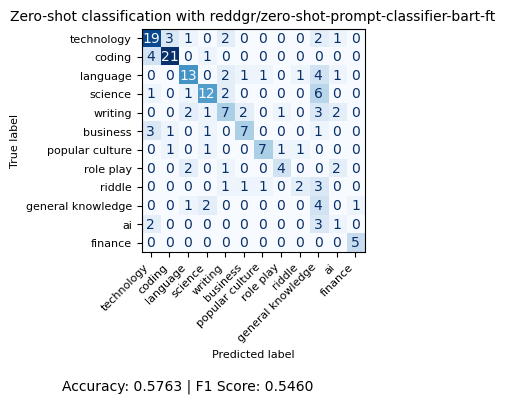

In [18]:
zs_classifier = tcf.ZeroShotClassifier(nli_model_path, nli_model_path, top_categories)
zs_test_metrics = zs_classifier.test_zs_predictions(test_entailments_df)

Zero-shot classification on test data:: 100%|██████████| 177/177 [08:43<00:00,  2.96s/it]


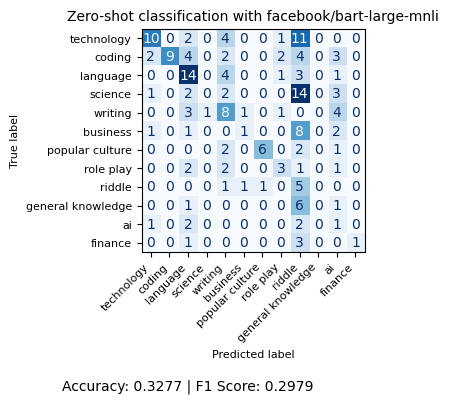

In [31]:
base_model_path = 'facebook/bart-large-mnli'
base_classifier = tcf.ZeroShotClassifier(base_model_path, nli_model_path, top_categories)
base_test_metrics = base_classifier.test_zs_predictions(test_entailments_df)

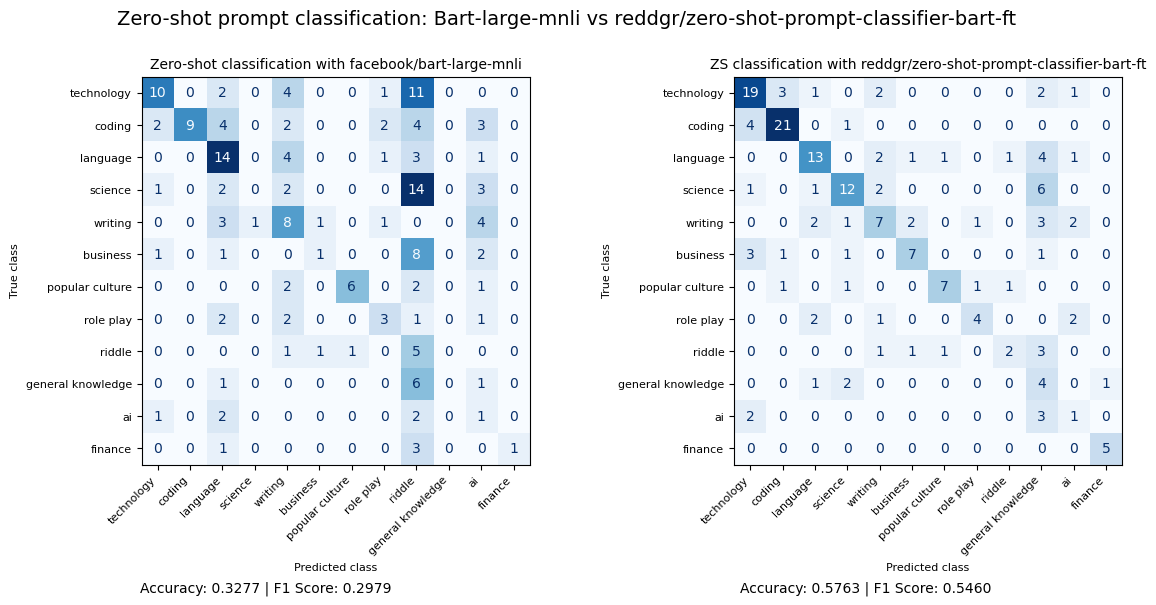

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Zero-shot prompt classification: Bart-large-mnli vs reddgr/zero-shot-prompt-classifier-bart-ft", fontsize=14)

# Plot for base_classifier (left)
disp1 = ConfusionMatrixDisplay(confusion_matrix=base_test_metrics["confusion_matrix"], display_labels=base_classifier.candidate_labels)
disp1.plot(cmap=plt.cm.Blues, ax=axes[0], colorbar=False)
axes[0].set_title(f"Zero-shot classification with {base_model_path}", fontsize=10)
axes[0].set_xlabel("Predicted class", fontsize=8)
axes[0].set_ylabel("True class", fontsize=8)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right", fontsize=8)
axes[0].set_yticklabels(axes[0].get_yticklabels(), fontsize=8)

fig.text(
    0.25, 0.01, 
    f"Accuracy: {base_test_metrics['accuracy']:.4f} | F1 Score: {base_test_metrics['f1_score']:.4f}",
    ha="center",
    fontsize=10
)

# Plot for zs_classifier (fine-tuned) (right)
disp2 = ConfusionMatrixDisplay(confusion_matrix=zs_test_metrics["confusion_matrix"], display_labels=zs_classifier.candidate_labels)
disp2.plot(cmap=plt.cm.Blues, ax=axes[1], colorbar=False)
axes[1].set_title(f"ZS classification with {nli_model_path}", fontsize=10)
axes[1].set_xlabel("Predicted class", fontsize=8)
axes[1].set_ylabel("True class", fontsize=8)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right", fontsize=8)
axes[1].set_yticklabels(axes[1].get_yticklabels(), fontsize=8)

fig.text(
    0.75, 0.01, 
    f"Accuracy: {zs_test_metrics['accuracy']:.4f} | F1 Score: {zs_test_metrics['f1_score']:.4f}",
    ha="center",
    fontsize=10
)

plt.tight_layout(rect=[0, 0.05, 1, 0.95]) 
plt.show()